In [5]:
# Import libraries
from io import StringIO
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import glob
from scipy.integrate import cumtrapz
from scipy.fft import fft
import numpy as np
from obspy import Trace

# load data directories
lunar_test_data_directory = './space_apps_2024_seismic_detection/data/lunar/test/data'
lunar_training_data_directory = './space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'

mars_test_data_directory = './space_apps_2024_seismic_detection/data/mars/test/data'
mars_training_data_directory = './space_apps_2024_seismic_detection/data/mars/training/data'

lunar_training_file = lunar_training_data_directory + 'xa.s12.00.mhz.1974-04-27HR00_evid00145.csv'



# l_training_df = pd.read_csv(lunar_training_file)
# # l_train_df = pd.read_csv()


In [10]:
# data cleaning tools

def clean_csv(file_path, output_path, log_file_path):
    df = pd.read_csv(file_path)

    # Initialize an empty list for log entries
    log_entries = []

    # Log missing values before dropping them
    if df.isnull().values.any():
        missing_data = df[df.isnull().any(axis=1)]
        for index, row in missing_data.iterrows():
            log_entries.append(f"Missing Data Removed: Index {index}, Data: {row.to_dict()}")

    # Remove rows with any missing values
    df.dropna(inplace=True)

    # Remove duplicate time entries (assuming 'time(%Y-%m-%dT%H:%M:%S.%f)' or 'time_abs(%Y-%m-%dT%H:%M:%S.%f)' is the time column)
    if 'time(%Y-%m-%dT%H:%M:%S.%f)' in df.columns:
        duplicate_rows = df[df.duplicated(subset='time(%Y-%m-%dT%H:%M:%S.%f)', keep=False)]
        for index, row in duplicate_rows.iterrows():
            log_entries.append(f"Duplicate Time Removed: Index {index}, Data: {row.to_dict()}")
        df.drop_duplicates(subset='time(%Y-%m-%dT%H:%M:%S.%f)', inplace=True)
    elif 'time_abs(%Y-%m-%dT%H:%M:%S.%f)' in df.columns:
        duplicate_rows = df[df.duplicated(subset='time_abs(%Y-%m-%dT%H:%M:%S.%f)', keep=False)]
        for index, row in duplicate_rows.iterrows():
            log_entries.append(f"Duplicate Time Removed: Index {index}, Data: {row.to_dict()}")
        df.drop_duplicates(subset='time_abs(%Y-%m-%dT%H:%M:%S.%f)', inplace=True)

    # Remove rows where velocity is -1 (assuming the column is named 'velocity(m/s)')
    if 'lunar' in file_path.lower():
        if 'velocity(m/s)' in df.columns:
            # Find rows where 'velocity(m/s)' is either -1 or -1.0
            unknown_velocity_data = df[(df['velocity(m/s)'] == -1) | (df['velocity(m/s)'] == -1.0)]
            
            # Log the data that is being removed
            for index, row in unknown_velocity_data.iterrows():
                log_entries.append(f"Unknown Velocity Removed (velocity=-1 or -1.0): Index {index}, Data: {row.to_dict()}")
            
            # Remove the rows where 'velocity(m/s)' is either -1 or -1.0
            df = df[(df['velocity(m/s)'] != -1) & (df['velocity(m/s)'] != -1.0)]

    # Save cleaned data to the output directory
    df.to_csv(output_path, index=False)

    # Write log entries to the log file
    with open(log_file_path, 'a') as log_file:
        log_file.write(f"Cleaning log for file: {file_path}\n")
        if log_entries:
            for entry in log_entries:
                log_file.write(entry + '\n')
        else:
            log_file.write("No data removed.\n")
        log_file.write("\n")

# Function to iterate over directories and clean CSV files
def clean_data_in_directory(input_directory, output_directory, log_file_path):
    # Traverse the directory tree
    for root, dirs, files in os.walk(input_directory):
        for file in files:
            if file.endswith('.csv'):
                # Determine the current CSV file path
                csv_file = os.path.join(root, file)
                
                # Determine output path for the cleaned CSV
                relative_path = os.path.relpath(csv_file, input_directory)
                output_path = os.path.join(output_directory, relative_path)

                # Create any necessary output subdirectories
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                # Clean and save the CSV file while logging changes
                clean_csv(csv_file, output_path, log_file_path)
                print(f"Cleaned file saved to: {output_path}")

In [11]:
# Data cleaning
# Put desired clean output directories here
clean_data_directory = './clean_data'
lunar_test_clean_directory = os.path.join(clean_data_directory, 'lunar/test')
lunar_training_clean_directory = os.path.join(clean_data_directory, 'lunar/training')
mars_test_clean_directory = os.path.join(clean_data_directory, 'mars/test')
mars_training_clean_directory = os.path.join(clean_data_directory, 'mars/training')

# Ensure the clean directories exist
os.makedirs(lunar_test_clean_directory, exist_ok=True)
os.makedirs(lunar_training_clean_directory, exist_ok=True)
os.makedirs(mars_test_clean_directory, exist_ok=True)
os.makedirs(mars_training_clean_directory, exist_ok=True)

# Path to cleaning log file
log_file_path = './cleaning_log.txt'

# clean out log file before populating
open(log_file_path, 'w')

# Clean data in each of the specified directories
clean_data_in_directory(lunar_test_data_directory, lunar_test_clean_directory, log_file_path)
clean_data_in_directory(lunar_training_data_directory, lunar_training_clean_directory, log_file_path)
clean_data_in_directory(mars_test_data_directory, mars_test_clean_directory, log_file_path)
clean_data_in_directory(mars_training_data_directory, mars_training_clean_directory, log_file_path)


Cleaned file saved to: ./clean_data/lunar/test/S16_GradeA/xa.s16.00.mhz.1972-11-14HR00_evid00081.csv
Cleaned file saved to: ./clean_data/lunar/test/S16_GradeA/xa.s16.00.mhz.1974-12-25HR00_evid00174.csv
Cleaned file saved to: ./clean_data/lunar/test/S16_GradeA/xa.s16.00.mhz.1975-03-26HR00_evid00186.csv
Cleaned file saved to: ./clean_data/lunar/test/S16_GradeA/xa.s16.00.mhz.1973-07-31HR00_evid00123.csv
Cleaned file saved to: ./clean_data/lunar/test/S16_GradeA/xa.s16.00.mhz.1974-05-19HR00_evid00146.csv
Cleaned file saved to: ./clean_data/lunar/test/S16_GradeA/xa.s16.00.mhz.1972-11-08HR00_evid00080.csv
Cleaned file saved to: ./clean_data/lunar/test/S16_GradeA/xa.s16.00.mhz.1975-02-19HR00_evid00180.csv
Cleaned file saved to: ./clean_data/lunar/test/S16_GradeA/xa.s16.00.mhz.1977-04-17HR00_evid00249.csv
Cleaned file saved to: ./clean_data/lunar/test/S16_GradeA/xa.s16.00.mhz.1972-11-06HR00_evid00079.csv
Cleaned file saved to: ./clean_data/lunar/test/S16_GradeA/xa.s16.00.mhz.1977-06-02HR00_evid

In [12]:
# create list of dataframes of clean data csv
# TODO: Not enough memory to use this

def populate_df_list(input_directory):
    output_df_list = []
    for root, dirs, files in os.walk(input_directory):
        for file in files:
            if file.endswith('.csv'):
                csv_file = os.path.join(root, file)
                try:
                    df = pd.read_csv(csv_file)
                    output_df_list.append(df)
                except Exception as e:
                    print(f"Error reading {csv_file}: {e}")
    return output_df_list

# lunar_test_df_list = populate_df_list('./clean_data/lunar/test')
# lunar_training_df_list = populate_df_list(lunar_training_clean_directory)
# mars_test_df_list = populate_df_list(mars_training_clean_directory)
# mars_training_df_list = populate_df_list(mars_test_clean_directory)

In [61]:
# TODO: alternative data tools
def convert_velocity_to_displacement(input_csv, output_csv):
    """
    Converts velocity data from CSV to displacement and writes to a new CSV.
    """
    df = pd.read_csv(input_csv)

    time = df['time_rel(sec)'].values
    velocity = df['velocity(m/s)'].values

    # Integrate velocity to obtain displacement
    displacement = cumtrapz(velocity, time, initial=0)  # initial=0 to start displacement at zero

    displacement_df = df.copy()
    displacement_df['displacement(m)'] = displacement

    displacement_df.to_csv(output_csv, index=False)

    print(f"Displacement data written to {output_csv}")
    
def convert_velocity_to_acceleration(input_csv, output_csv):
    """
    Converts velocity data from CSV to acceleration and writes to a new CSV.
    """
    df = pd.read_csv(input_csv)

    time = df['time_rel(sec)'].values
    velocity = df['velocity(m/s)'].values

    acceleration = np.gradient(velocity, time)  # differentiation to get acceleration

    acceleration_df = df.copy()
    acceleration_df['acceleration(m/s^2)'] = acceleration

    acceleration_df.to_csv(output_csv, index=False)

    print(f"Acceleration data written to {output_csv}")


# convert_velocity_to_displacement(lunar_training_file, './lunar_displacement.csv')
# convert_velocity_to_acceleration(lunar_training_file, './lunar_acceleration.csv')

def plot_displacement_over_time(input_csv):
    """
    Plots displacement over time from a CSV file containing displacement data.
    """
    df = pd.read_csv(input_csv)

    time = pd.to_datetime(df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'])
    displacement = df['displacement(m)'].values

    plt.figure(figsize=(10, 6))
    plt.plot(time, displacement, label='Displacement Over Time', color='b')
    plt.xlabel('Time (Day Hour:Minute)')
    plt.ylabel('Displacement (meters)')
    plt.title('Displacement Over Time')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# plot_displacement_over_time('lunar_displacement.csv')

def plot_acceleration_over_time(input_csv):
    """
    Plots acceleration over time from a CSV file containing acceleration data.
    """
    df = pd.read_csv(input_csv)

    time = pd.to_datetime(df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'])
    acceleration = df['acceleration(m/s^2)'].values

    plt.figure(figsize=(10, 6))
    plt.plot(time, acceleration, label='Acceleration Over Time', color='r')
    plt.xlabel('Time (Day Hour:Minute)')
    plt.ylabel('Acceleration (m/s²)')
    plt.title('Acceleration Over Time')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def plot_velocity_over_time(input_csv):
    """
    Plots velocity over time from a CSV file containing velocity data.
    """
    df = pd.read_csv(input_csv)

    time = pd.to_datetime(df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'])
    velocity = df['velocity(m/s)'].values

    plt.figure(figsize=(10, 6))
    plt.plot(time, velocity, label='Velocity Over Time', color='r')
    plt.xlabel('Time (Day Hour:Minute)')
    plt.ylabel('velocity (m/s)')
    plt.title('velocity Over Time')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_acceleration_over_time('lunar_acceleration.csv')

def plot_frequency_spectrum(input_csv):
    df = pd.read_csv(input_csv)
    time = df['time_rel(sec)'].values
    velocity = df['velocity(m/s)'].values
    
    # Apply fast fourier transform to velocity data
    N = len(velocity)
    velocity_fft = fft(velocity)
    frequency = np.fft.fftfreq(N, d=(time[1] - time[0]))

    # Plot frequency spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(frequency[:N // 2], np.abs(velocity_fft)[:N // 2], label='Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title('Frequency Spectrum of    Velocity Data')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
# plot_frequency_spectrum(lunar_training_file)

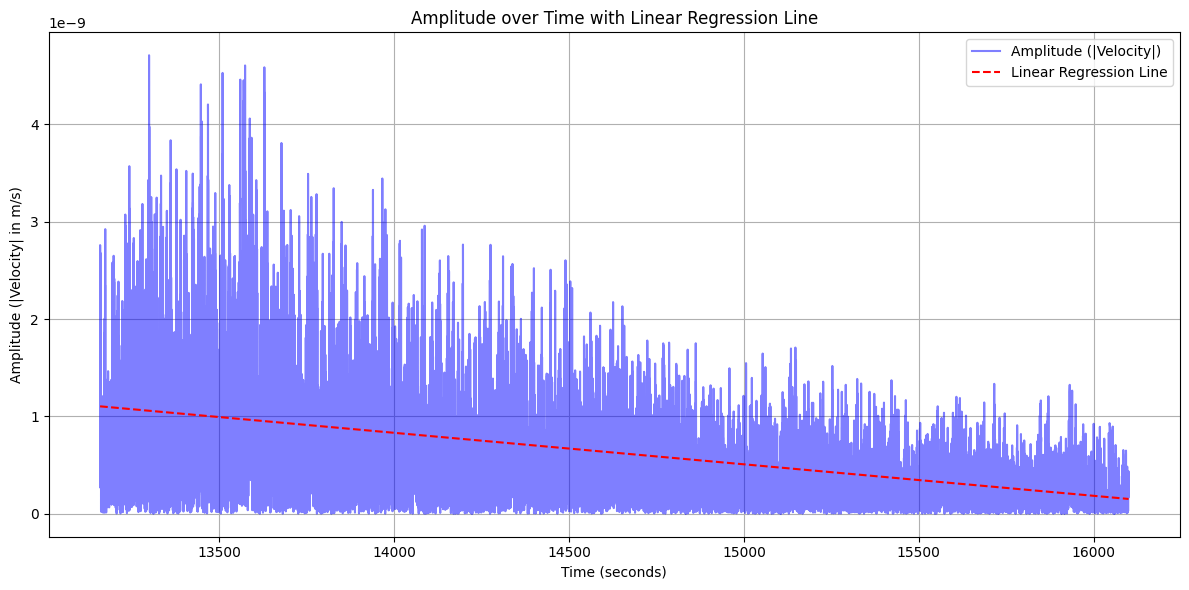

Slope: -3.233525774394476e-13
R² (correlation coefficient): 0.2111443354601028


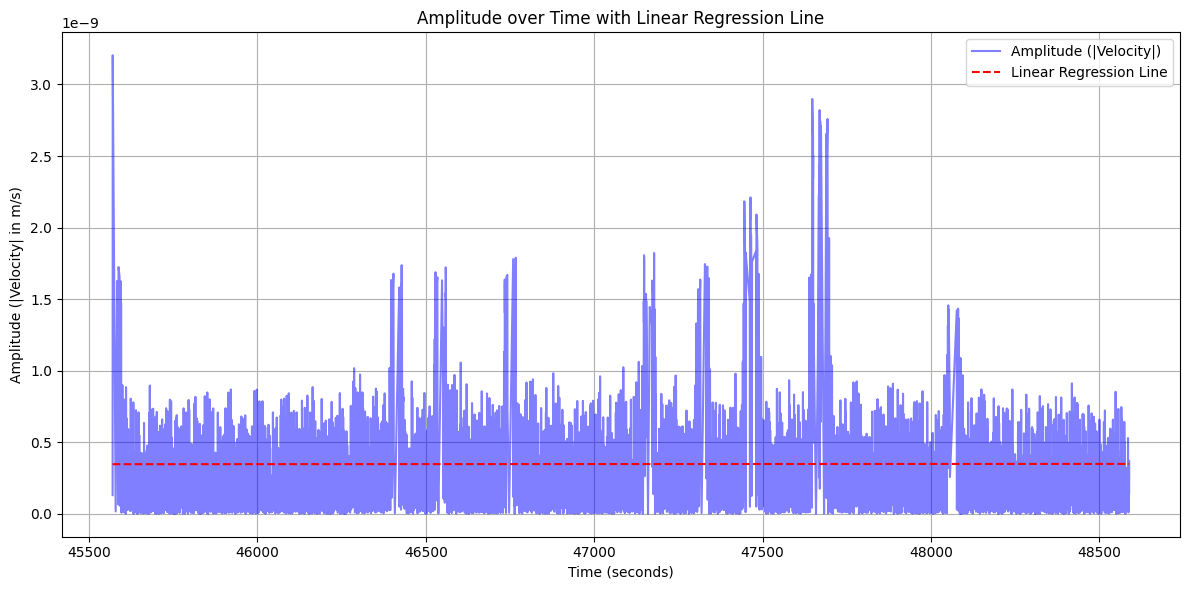

Slope: 6.953807051693263e-16
R² (correlation coefficient): 2.3671357054499964e-06


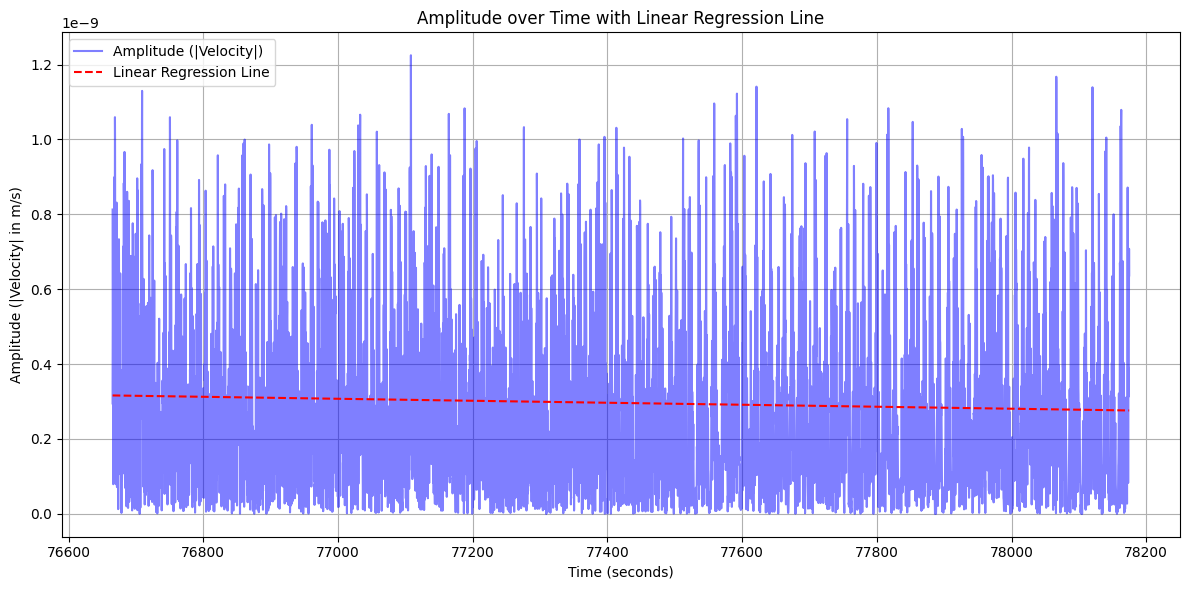

Slope: -2.6550655711286722e-14
R² (correlation coefficient): 0.0026828215237147957


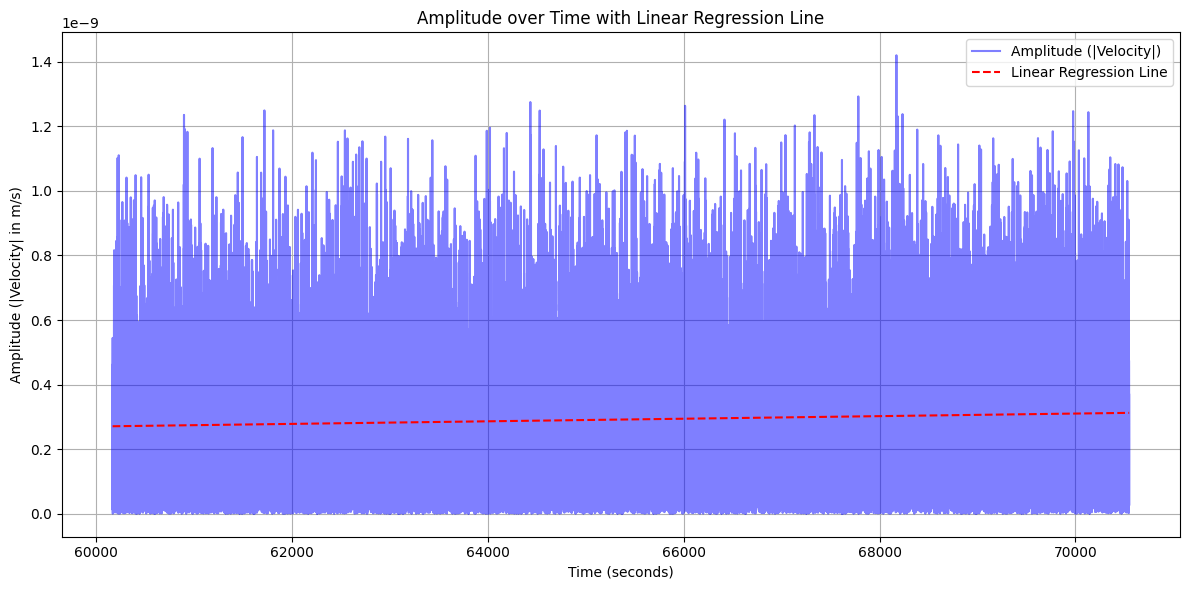

Slope: 3.996770893628088e-15
R² (correlation coefficient): 0.003152282308077403


In [12]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

def extract_rows(input_csv, output_csv, start_row, end_row):
    df = pd.read_csv(input_csv, skiprows=lambda x: x not in range(0, end_row) or (x > 0 and x < start_row))
    df.to_csv(output_csv, index=False)
    
test_file = "./space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-03-25HR00_evid00003.csv"
extract_rows(test_file, 'sliced.csv', 87178, 106664)
extract_rows(test_file, 'sliced2.csv', 301902, 321902)
extract_rows(test_file, 'sliced3.csv', 507909,517909)
extract_rows(test_file, 'sliced4.csv', 398604,467389)


def is_seismic(input_csv):
    """
    Analyzes amplitude (absolute value of velocity) over time data by performing linear regression,
    returning the correlation (R²), and plotting the amplitude data with the regression line.

    Parameters:
    - input_csv (str): Path to the CSV file containing the data.

    Returns:
    - float: The correlation coefficient (R² value) representing the linear fit.
    """
    # Load the CSV data
    df = pd.read_csv(input_csv)

    # Extract time and velocity columns
    if 'time_rel(sec)' not in df.columns or 'velocity(m/s)' not in df.columns:
        raise ValueError("CSV must contain 'time_rel(sec)' and 'velocity(m/s)' columns.")
    
    time = df['time_rel(sec)'].values.reshape(-1, 1)  # Reshape to be used as input in sklearn
    velocity = df['velocity(m/s)'].values

    # Calculate amplitude as the absolute value of velocity
    amplitude = np.abs(velocity)

    # Fit linear regression to the amplitude data
    model = LinearRegression()
    model.fit(time, amplitude)

    # Get the slope and correlation coefficient (R² value)
    slope = model.coef_[0]
    r_squared = model.score(time, amplitude)

    # Generate predicted values for the regression line on amplitude
    amplitude_pred = model.predict(time)

    # Plotting the amplitude data and the regression line
    plt.figure(figsize=(12, 6))
    plt.plot(time, amplitude, label='Amplitude (|Velocity|)', color='blue', alpha=0.5)
    plt.plot(time, amplitude_pred, label='Linear Regression Line', color='red', linestyle='--')

    # Adding labels and title to the plot
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (|Velocity| in m/s)')
    plt.title('Amplitude over Time with Linear Regression Line')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print slope and R² value for verification
    print(f"Slope: {slope}")
    print(f"R² (correlation coefficient): {r_squared}")

    # Return the correlation coefficient (R² value)
    return r_squared

is_seismic('sliced.csv')
is_seismic('sliced2.csv')
is_seismic('sliced3.csv')
is_seismic('sliced4.csv')


# plot_velocity_over_time('sliced.csv')
# plot_velocity_over_time('sliced2.csv')
# plot_velocity_over_time('sliced3.csv')
# plot_velocity_over_time('sliced4.csv')

# print(is_seismic_feature('sliced.csv'))

from scipy.signal import welch

def csv_to_psd(input_csv, column_name='velocity(m/s)', fs=1.0, nperseg=1024):
    """
    Convert data from a CSV file to a Power Spectral Density (PSD) plot.

    Parameters:
    - input_csv (str): Path to the CSV file containing the data.
    - column_name (str): Name of the column to analyze (default is 'velocity(m/s)').
    - fs (float): Sampling frequency of the data (in Hz).
    - nperseg (int): Length of each segment for Welch's method (default is 1024).
    """
    # Load the CSV data
    df = pd.read_csv(input_csv)

    # Extract the specified column data
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in CSV file.")
    data = df[column_name].values

    # Compute the Power Spectral Density using Welch's method
    frequencies, psd = welch(data, fs=fs, nperseg=nperseg)

    # Plot the PSD
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, psd, color='b')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (V^2/Hz)')
    plt.title('Power Spectral Density (PSD)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# csv_to_psd('sliced.csv')
# csv_to_psd('sliced2.csv')
# csv_to_psd('sliced3.csv')
# csv_to_psd('sliced4.csv')

In [ ]:
from obspy.signal.trigger import classic_sta_lta, trigger_onset
lunar_cat_directory = './space_apps_2024_seismic_detection/data/lunar/training/catalogs/'
lunar_cat_file = lunar_cat_directory + 'apollo12_catalog_GradeA_final.csv'
lunar_cat = pd.read_csv(lunar_cat_file)

# load data directories
lunar_training_data_directory = './space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'
mars_training_data_directory = './space_apps_2024_seismic_detection/data/mars/training/data'


lunar_training_file = lunar_training_data_directory + lunar_cat['filename'][0] + '.csv'
l_training_df = pd.read_csv(lunar_training_file)

def sta_lta(df, sta, lta, thr_on, thr_off):
    velocity = df["velocity(m/s)"]
    rel_time = np.array(df["time_rel(sec)"])
    samp_rate = 1/(rel_time[1] - rel_time[0])

    cft = classic_sta_lta(velocity, int(sta * samp_rate), int(lta * samp_rate))
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    # fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    # ax.plot(rel_time,cft)
    # ax.set_xlim([min(rel_time),max(rel_time)])
    # ax.set_xlabel('Time (s)')
    # ax.set_ylabel('Characteristic function')


    times = []
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    for i in np.arange(0, len(on_off)):
        trigger = on_off[i]
        abs_time = l_training_df["time_abs(%Y-%m-%dT%H:%M:%S.%f)"][trigger[0]]
        times.append((abs_time, rel_time[trigger[0]]))
        ax.axvline(x = rel_time[trigger[0]], color='red', label='Trig. On')
        ax.axvline(x = rel_time[trigger[1]], color='purple', label='Trig. Off')

    ax.plot(rel_time, velocity)
    ax.set_xlim([min(rel_time),max(rel_time)])
    ax.legend()   

    return times

sta_len, lta_len = 1500, 10000
on, off = 2, 1

def analyze_seismic_events(input_csv, sta, lta, thr_on, thr_off):
    """
    Analyzes a CSV file for seismic events by finding trigger on-off times using STA/LTA,
    slicing the CSV file for each event, and performing linear regression on the amplitude
    data of each slice.

    Parameters:
    - input_csv (str): Path to the CSV file containing the data.
    - sta (float): Short Time Average window length in seconds.
    - lta (float): Long Time Average window length in seconds.
    - thr_on (float): Trigger on threshold.
    - thr_off (float): Trigger off threshold.
    """
    # Load the CSV data
    df = pd.read_csv(input_csv)

    # Extract trigger on and off times using STA/LTA method
    on_off_times = sta_lta(df, sta, lta, thr_on, thr_off)

    # Iterate over each trigger on-off pair to slice and analyze the CSV data
    for i, (abs_time, rel_time_on) in enumerate(on_off_times):
        trigger_start_idx = df[df['time_rel(sec)'] == rel_time_on].index[0]
        trigger_end_idx = df[df['time_rel(sec)'] == on_off_times[i][1]].index[0]
        
        # Extract the rows from start to end for the triggered event
        sliced_filename = f"sliced_event_{i + 1}.csv"
        extract_rows(input_csv, sliced_filename, trigger_start_idx, trigger_end_idx)

        # Run linear regression on the amplitude of the sliced CSV
        r_squared_value = is_seismic(sliced_filename)
        print(f"Event {i + 1} - Correlation Coefficient (R²): {r_squared_value}")


# Example usage
test_file = "./space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-03-25HR00_evid00003.csv"
sta_lta(l_training_df, sta_len, lta_len, on, off)
analyze_seismic_events(test_file, sta=1, lta=10, thr_on=1.5, thr_off=0.5)